In [43]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.0


In [3]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index][-6:]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()[-6:]
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0], additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd,Delq FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
delq_results = dict()
while res:
    vin6 = res[0].strip()[-6:]
    loan_results[vin6] = res[1].strip()
    delq_results[vin6] = res[2]
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
default_delq = ["NA" for i in range(len(df))]
df['Result'] = default_result
df['Delq'] = default_delq

df = df[df['OpeningBalance']!=0]

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    df.loc[df['VIN'] == vin6, ['Result', 'Delq']] = [res, delq_results[vin6]]

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Delq", "Result"]]

print(df['Delq'])

df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df['DelqPct'] = df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
df.fillna(df.mean(), inplace=True)

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]
print(df['DelqPct'])

Assigning Additional Entities


100%|██████████| 28023/28023 [00:40<00:00, 692.95it/s]


Assigning Results


100%|██████████| 24961/24961 [00:37<00:00, 663.09it/s]


0           0
1           0
2           0
3        1266
4           0
         ... 
17657      NA
17658      NA
17659      NA
17660      NA
17661      NA
Name: Delq, Length: 17660, dtype: object
0         0.000000
1         0.000000
2         0.000000
3         8.573042
4         0.000000
           ...    
17361     0.000000
17536     0.000000
17560     1.589734
17588     0.000000
17639    13.178456
Name: DelqPct, Length: 10306, dtype: float64


In [4]:
# fig, axes = plt.subplots(ncols=3)
# for i, yvar in enumerate(df.columns):
#     axes[i].scatter(df['Result'],df[yvar])

# pp = sns.pairplot(data=df,
#                   y_vars=["DelqPct"],
#                   x_vars=df.columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


resdict= dict()
rdict = dict()

num_features = [i for i in range(1, len(df.columns)-2)]

# for nf in tqdm(num_features):
#     linReg = LinearRegression()
#     rfe = RFE(estimator = linReg, n_features_to_select = nf)
#     rfe.fit(x_train, y_train.values.ravel())
#
#
#     train_pred = rfe.predict(x_train)
#     test_pred = rfe.predict(x_test)
#
#     resdict[nf] = np.sqrt(metrics.mean_squared_error(y_test, test_pred))
#     rdict[nf] = metrics.r2_score(y_test, test_pred)

print(resdict)
print(rdict)

linReg = LinearRegression()
rfe = RFE(estimator = linReg, n_features_to_select = 59)
rfe.fit(x_train, y_train.values.ravel())


train_pred = rfe.predict(x_train)
test_pred = rfe.predict(x_test)

print("LinearRegression")
print("R^2 : ", metrics.r2_score(y_test, test_pred))
print("MAE :", metrics.mean_absolute_error(y_test,test_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, test_pred)))


{}
{}
LinearRegression
R^2 :  0.07157679040868947
MAE : 4.300789401140549
RMSE: 5.268459343081297


In [6]:
# print(y_train)

x_train = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train).fit()
print(est.summary())


                            OLS Regression Results                            
Dep. Variable:                DelqPct   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     23.86
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          3.58e-133
Time:                        20:34:10   Log-Likelihood:                -25392.
No. Observations:                8244   AIC:                         5.085e+04
Df Residuals:                    8211   BIC:                         5.108e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [7]:
x_test = sm.add_constant(x_test)

print(est.predict(x_train[:5]))
print(y_train[:5])


636      4.108177
236      4.997236
10676    2.951293
9936     4.196345
9262     6.987687
dtype: float64
         DelqPct
636    13.863232
236     8.154454
10676   0.744027
9936    0.000000
9262   10.048679


### TensorFlow

In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


Metal device set to: Apple M1 Pro


2023-02-28 20:34:10.418565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 20:34:10.418726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-28 20:34:10.487967: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-28 20:34:10.552717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-28 20:34:10.583484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[8.35630722e+01 3.05338403e+03 3.53715759e+02 7.15448181e+02
  2.06968311e+03 1.07979305e+05 1.05801855e+04 3.00872656e+03
  4.45686455e+01 2.01085938e+03 4.54750702e+02 1.32967341e+00
  2.76270419e-01 9.87008286e+00 2.20259375e+04 1.29427552e-01
  3.88161070e-03 1.46288204e+00 2.94759907e-02 4.03469372e+00
  1.37003851e+01 5.69772053e+00 4.45076408e+01 1.73107731e+00
  1.17819047e+00 4.97052574e+00 2.56950521e+00 7.00060511e+00
  4.03178310e+00 2.61943283e+01 8.57807617e+01 2.24153906e+03
  2.94759907e-02]]


In [9]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [10]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 33)               67        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2176      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,468
Trainable params: 6,401
Non-trainable params: 67
_________________________________________________________________


In [11]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023-02-28 20:34:11.598274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-28 20:34:13.386658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 20s, sys: 38.9 s, total: 1min 59s
Wall time: 2min 1s


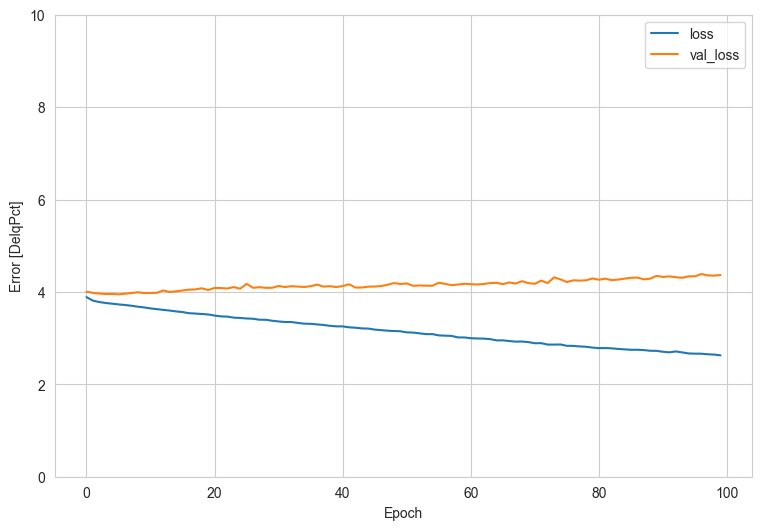

In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DelqPct]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.
#which looks to be exactly what is happening here

In [16]:
test_results = dict()
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [DelqPCT]']).T

,Mean absolute error [DelqPCT]
dnn_model,4.38892


65/65 [==============================] - 0s 2ms/step
[ 0.44031122  5.6933193  -0.18954054  0.94019634 10.80282   ]
        DelqPct
2458   9.560600
6532   0.000000
4339   9.146635
3065  11.170000
5488  17.009102


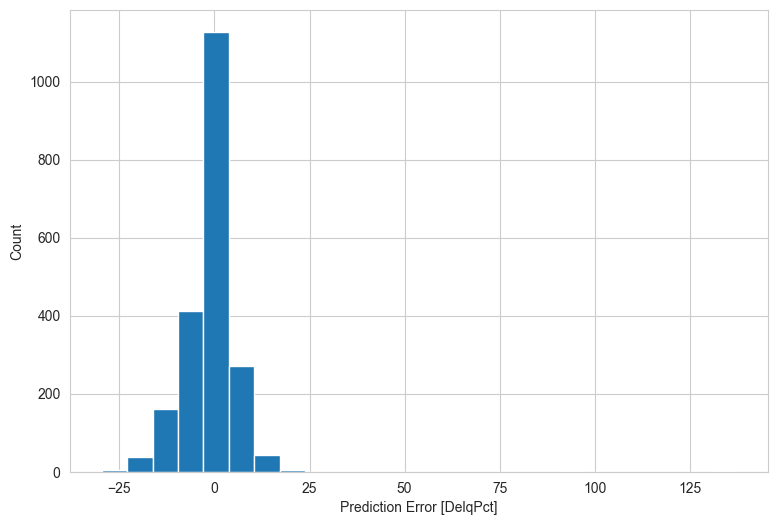

In [35]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions[:5])
print(test_labels[:5])

error = test_predictions.reshape(test_predictions.shape[0],1) - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DelqPct]')
_ = plt.ylabel('Count')

### XGBoost

In [50]:
xgdata = df.copy(deep=True)
for x in tqdm(range(100)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

  5%|▌         | 5/100 [00:35<11:19,  7.15s/it]


KeyboardInterrupt: 

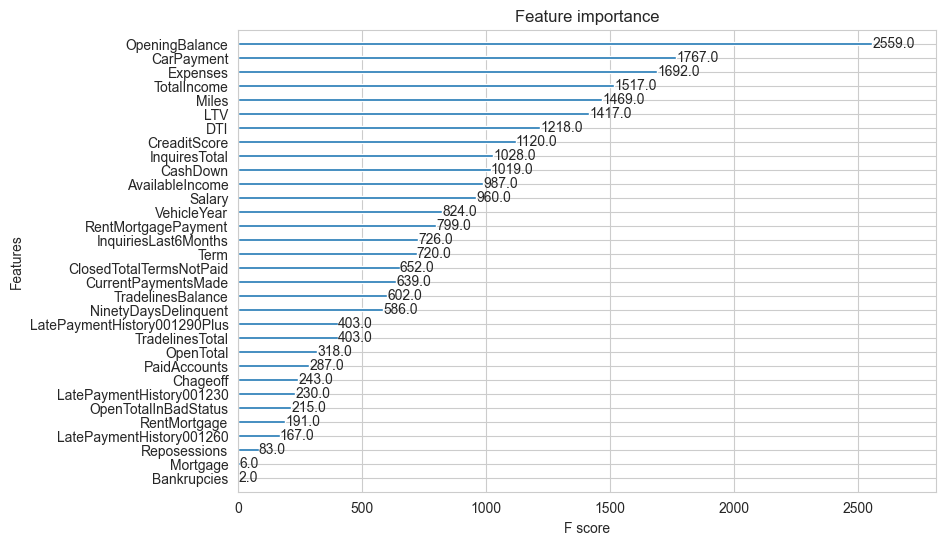

In [51]:
xgb_ml = xgb.Booster()
xgb_ml.load_model('Models/Delq/XGBoost_6.582%_Scorelate.json')


# plot feature importance
plot_importance(xgb_ml)
plt.show()